In [4]:
#Initialization

import jax.numpy as jnp
import matplotlib.pyplot as plt

import jax

#test tools
import test_utils

#setting plot default parameters
plt.rcParams['figure.figsize'] = (10.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


Show an example:


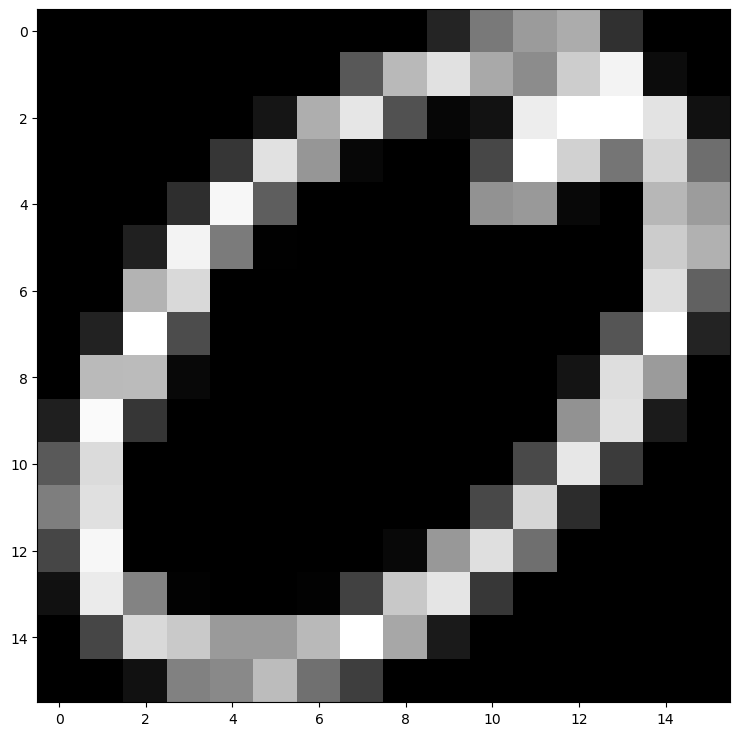

label: 0 

Train data shape:  (9000, 256)
Train labels shape:  (9000,)
Validation data shape:  (1000, 256)
Validation labels shape:  (1000,)
Test data shape:  (1000, 256)
Test labels shape:  (1000,)


In [5]:
# Load the data

X_train = jnp.load('X_train.npy')
y_train = jnp.load('y_train.npy')
X_val = jnp.load('X_val.npy')
y_val = jnp.load('y_val.npy')
X_test = jnp.load('X_test.npy')
y_test = jnp.load('y_test.npy')

print('Show an example:')
a0 = X_train[100,:].reshape(16,16)
plt.imshow(a0)
plt.show()
print('label:', y_train[100], '\n')

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

In [6]:
#Example of mutation in numpy

import numpy as np
x = np.arange(10)
print('Numpy array before mutation:\n{}'.format(x))
x[0:5] = 10
print('Numpy array after mutation:\n{}'.format(x))

Numpy array before mutation:
[0 1 2 3 4 5 6 7 8 9]
Numpy array after mutation:
[10 10 10 10 10  5  6  7  8  9]


In [ ]:
# jax do not support!
try:
    # THIS WILL CAUSE AN ERROR !!!
    x = jnp.arange(10)
    x[0] = 10
except TypeError as err:
    print('CATCH AN TYPE ERROR!')
    print(err)

CATCH AN TYPE ERROR!
'<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


In [8]:
x = jnp.arange(10)
print('JAX array before mutation:\n{}'.format(x))
x = x.at[0:5].set(10)
print('JAX array after mutation:\n{}'.format(x))

JAX array before mutation:
[0 1 2 3 4 5 6 7 8 9]
JAX array after mutation:
[10 10 10 10 10  5  6  7  8  9]


## Forward

In [9]:
#Example for generate random numbers in JAX
from jax import random

#WRONG Example!
key = random.PRNGKey(0)
print('WRONG: Using same key will have same random samples!')
for i in range(3):
    normal_sample = random.normal(key, shape = [3])
    print('Random array {} : {}'.format(i, normal_sample))

print('\n------------\n')

#Good Example
key = random.PRNGKey(0)
print('Correct: Using new subkeys')
for i in range(3):
    key, subkey = random.split(key)
    normal_sample = random.normal(subkey, shape = [3])
    print('Random array {} : {}'.format(i, normal_sample))

WRONG: Using same key will have same random samples!
Random array 0 : [ 1.8160863  -0.48262316  0.33988908]
Random array 1 : [ 1.8160863  -0.48262316  0.33988908]
Random array 2 : [ 1.8160863  -0.48262316  0.33988908]

------------

Correct: Using new subkeys
Random array 0 : [ 1.1378784  -1.2209548  -0.59153634]
Random array 1 : [-0.06607257  0.16676573  1.1780034 ]
Random array 2 : [-2.2051446  -0.90678614 -0.51053447]


In [10]:
#Test run for task 1

import Network

hidden_size = 256

params = Network.init(hidden_size, random_seed = 0)
loss, predict, states = Network.forward_pass(params, X_train, y_train)
print('Loss = %f' % loss)

Loss = 2.302585


## BackProp

In [11]:
#Test run for task2+3 

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5
wd_decay = 0.05
delta = 1e-2

params = Network.init(input_size = input_size, hidden_size = hidden_size, output_size = num_classes, random_seed = 0, std=1e-1)
X, y = test_utils.init_toy_data(num_inputs, input_size, num_classes)

loss, predict, states = Network.forward_pass(params, X, y, wd_decay = wd_decay)
grads = Network.back_prop(params, states, X, y, wd_decay = wd_decay)
num_grads = Network.numerical_gradient(params, X, y, wd_decay = wd_decay, delta = delta)

# Errors should all be less than 1e-2 or so

for param_name in grads:
    print('%s relative error: %e' % (param_name, test_utils.rel_error(num_grads[param_name], grads[param_name])))


W2 relative error: 1.851859e-05
b2 relative error: 9.046243e-06
W1 relative error: 4.959189e-02
b1 relative error: 3.965820e-02


## Optional: JIT

In [12]:
#Example for JIT

import timeit

def norm(x):
    x = x - x.mean(0)
    return x / x.std(0)

@jax.jit
def norm_jit(x):
    x = x - x.mean(0)
    return x / x.std(0)

key = jax.random.PRNGKey(0)
x = jax.random.normal(key, shape = [10000, 10])

%timeit norm(x).block_until_ready()
%timeit norm_jit(x).block_until_ready()

481 µs ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
476 µs ± 43 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## SGD


iteration 0 / 200: training loss 2.302585 val loss: 2.302718
iteration 10 / 200: training loss 2.335719 val loss: 2.311285
iteration 20 / 200: training loss 2.185594 val loss: 2.169381
iteration 30 / 200: training loss 1.703610 val loss: 1.721180
iteration 40 / 200: training loss 1.543830 val loss: 1.579623
iteration 50 / 200: training loss 1.773627 val loss: 1.615199
iteration 60 / 200: training loss 1.675154 val loss: 1.599752
iteration 70 / 200: training loss 1.454804 val loss: 1.482940
iteration 80 / 200: training loss 1.325440 val loss: 1.363041
iteration 90 / 200: training loss 1.494965 val loss: 1.323216
iteration 100 / 200: training loss 1.274299 val loss: 1.299463
iteration 110 / 200: training loss 1.221558 val loss: 1.215462
iteration 120 / 200: training loss 1.264409 val loss: 1.277208
iteration 130 / 200: training loss 1.500118 val loss: 1.289396
iteration 140 / 200: training loss 1.162604 val loss: 1.155676
iteration 150 / 200: training loss 1.178339 val loss: 1.132165
ite

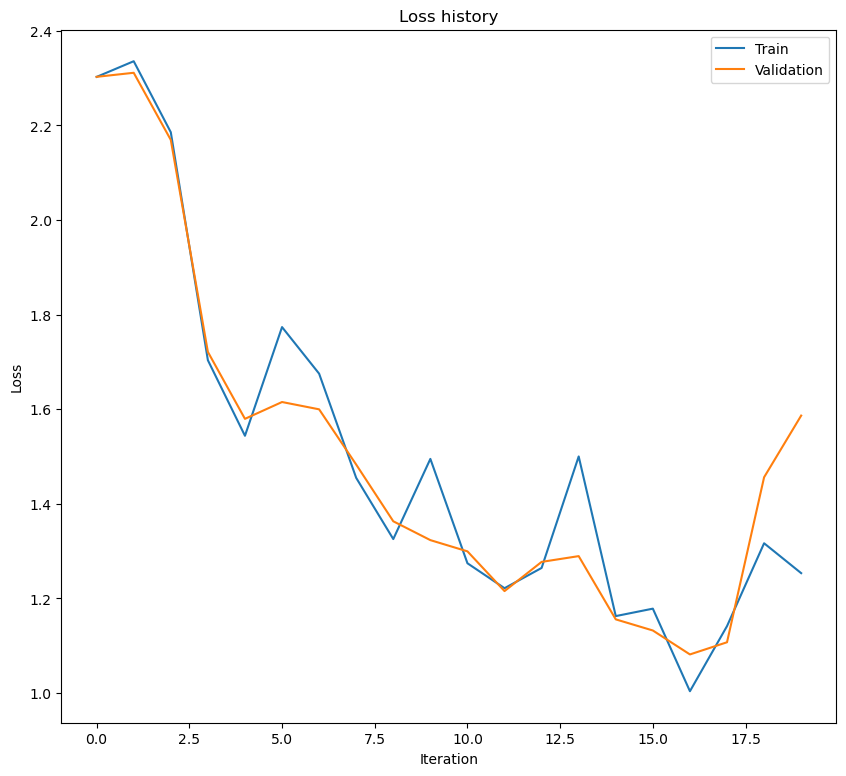

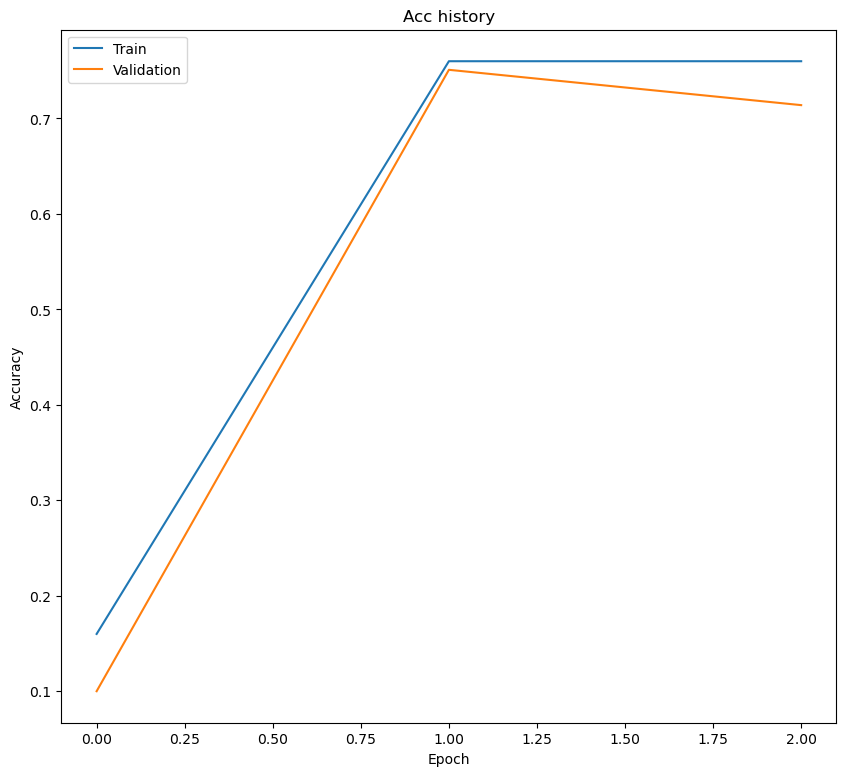

Final accuracy on test set: 0.80500007


In [13]:
# Test run for task 4

hidden_size = 10
random_seed = 0

params = Network.init(random_seed = random_seed, hidden_size = hidden_size)

stats, best_params = Network.train(params, X_train, y_train, X_val, y_val, random_seed = random_seed,
            learning_rate=0.5, momentum=0.9, wd_decay=0.02, 
            num_iters=200, batch_size=100,
            do_early_stopping=False,
            print_every=10, verbose=True)

test_utils.plot_loss_history(stats['loss_history'], stats['val_loss_history'])
test_utils.plot_acc_history(stats['acc_history'],stats['val_acc_history'])
print('Final accuracy on test set:', Network.get_acc(best_params, X_test, y_test))

## Adding Training Strategies

iteration 0 / 2000: training loss 2.302592 val loss: 2.302724
iteration 50 / 2000: training loss 1.392031 val loss: 1.221982
iteration 100 / 2000: training loss 1.065954 val loss: 1.079843
iteration 150 / 2000: training loss 1.212496 val loss: 1.130052
iteration 200 / 2000: training loss 1.004328 val loss: 1.043041
iteration 250 / 2000: training loss 1.223512 val loss: 1.306633
iteration 300 / 2000: training loss 1.080015 val loss: 1.176414
iteration 350 / 2000: training loss 1.071704 val loss: 1.028394
iteration 400 / 2000: training loss 1.097029 val loss: 1.070246
iteration 450 / 2000: training loss 1.022327 val loss: 1.030736
iteration 500 / 2000: training loss 1.274472 val loss: 1.131308
iteration 550 / 2000: training loss 1.399697 val loss: 1.156562
iteration 600 / 2000: training loss 1.067595 val loss: 1.028296


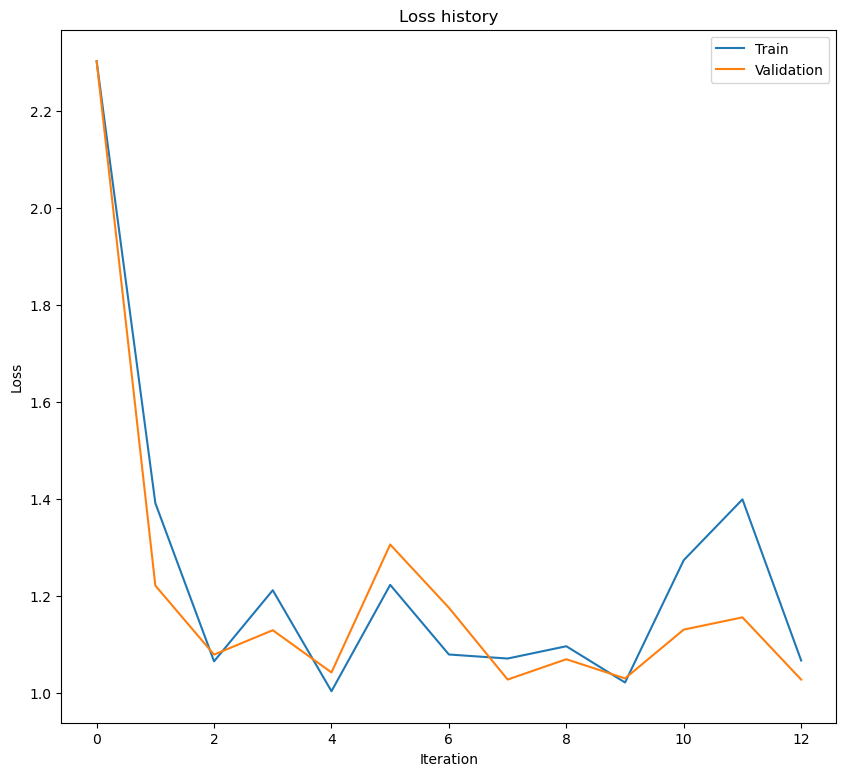

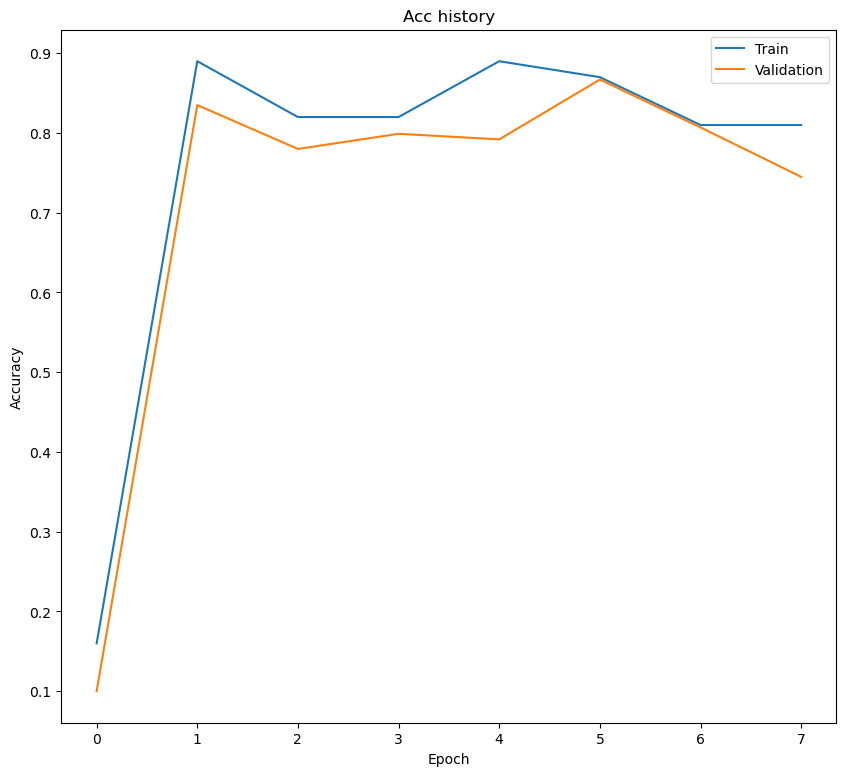

Final accuracy on test set: 0.749


In [14]:
# 
# TODO : training process with early stop and learning rate decay
#
# Hint : you may need additional hyperparameters

hidden_size = 256
random_seed = 0

params = Network.init(random_seed = random_seed, hidden_size = hidden_size)

stats, best_params = Network.train(params, X_train, y_train, X_val, y_val, random_seed = random_seed,
            learning_rate=0.5, momentum=0.9, wd_decay=0.02, 
            num_iters=2000, batch_size=100,
            do_early_stopping=True,
            print_every=50, verbose=True)

test_utils.plot_loss_history(stats['loss_history'], stats['val_loss_history'])
test_utils.plot_acc_history(stats['acc_history'], stats['val_acc_history'])
print('Final accuracy on test set:', Network.get_acc(best_params, X_test, y_test))

## Tuning

In [22]:
# Test run for task 5

#
# TODO : Tuning 
#
import Network

# Hyperparameters
learning_rates = [1e-1, 3e-1, 5e-1, 7e-1, 9e-1]
regularization_strengths = [0.01, 0.02, 0.04, 0.06]
num_iters = 2000
batch_size = 100
learning_rate_decay = [0.98, 0.9, 0.85, 0.8]

# Net structure
input_size = 256
hidden_size = [75, 150, 200, 256]
num_classes = 10
random_seed = 0

# Initialization
best_hidden_size = None
best_lr = None
best_lr_decay = None
best_reg = None
best_val = -1
results = {}

# Train the two layers network
for i in range(len(hidden_size)):
    for lr in learning_rates:
        for reg in regularization_strengths:
            for lr_decay in learning_rate_decay:
                params = Network.init(input_size = input_size, hidden_size = hidden_size[i], output_size = num_classes, random_seed = random_seed)
                stats, best_params = Network.train(params, X_train, y_train, X_val, y_val, random_seed = random_seed,
                learning_rate=lr, momentum=0.9, wd_decay=reg, lr_decay = lr_decay,
                num_iters=num_iters, batch_size=batch_size,
                do_early_stopping=True,
                print_every=50, verbose=True)
                train_accuracy = stats['acc_history'][-1]
                val_accuracy = stats['val_acc_history'][-1]
                if val_accuracy > best_val:
                    best_lr = lr
                    best_lr_decay = lr_decay
                    best_reg = reg
                    best_val = val_accuracy
                    best_hidden_size = hidden_size[i]
                results[(lr, reg, lr_decay)] = train_accuracy, val_accuracy
                print('hidden_size: %d lr: %e lr_decay: %e reg: %e train accuracy: %f val accuracy: %f' %
                  (hidden_size[i], lr, lr_decay, reg, results[(lr, reg, lr_decay)][0], results[(lr, reg, lr_decay)][1]))
print('Best hidden_size: %d\nBest lr: %e\nBest lr_decay: %e\nBest reg: %e\ntrain accuracy: %f\nval accuracy: %f' %
     (best_hidden_size, best_lr, best_lr_decay, best_reg, results[(best_lr, best_reg, best_lr_decay )][0], results[(best_lr, best_reg, best_lr_decay)][1]))

iteration 0 / 2000: training loss 2.302586 val loss: 2.302591
iteration 50 / 2000: training loss 2.017111 val loss: 1.986414
iteration 100 / 2000: training loss 0.742690 val loss: 0.766918
iteration 150 / 2000: training loss 0.470382 val loss: 0.583284
iteration 200 / 2000: training loss 0.495258 val loss: 0.570314
iteration 250 / 2000: training loss 0.472855 val loss: 0.554269
iteration 300 / 2000: training loss 0.496794 val loss: 0.564425
iteration 350 / 2000: training loss 0.529934 val loss: 0.562060
iteration 400 / 2000: training loss 0.501773 val loss: 0.540658
iteration 450 / 2000: training loss 0.535236 val loss: 0.553958
iteration 500 / 2000: training loss 0.530827 val loss: 0.526868
iteration 550 / 2000: training loss 0.521663 val loss: 0.527677
iteration 600 / 2000: training loss 0.446153 val loss: 0.533121
iteration 650 / 2000: training loss 0.424965 val loss: 0.521872
iteration 700 / 2000: training loss 0.552490 val loss: 0.527498
iteration 750 / 2000: training loss 0.51346

iteration 300 / 2000: training loss 0.693252 val loss: 0.763814
iteration 350 / 2000: training loss 0.752465 val loss: 0.786803
iteration 400 / 2000: training loss 0.723845 val loss: 0.736592
iteration 450 / 2000: training loss 0.809816 val loss: 0.776149
hidden_size: 75 lr: 1.000000e-01 lr_decay: 9.800000e-01 reg: 2.000000e-02 train accuracy: 0.900000 val accuracy: 0.918000
iteration 0 / 2000: training loss 2.302587 val loss: 2.302592
iteration 50 / 2000: training loss 2.136669 val loss: 2.122902
iteration 100 / 2000: training loss 0.898323 val loss: 0.931055
iteration 150 / 2000: training loss 0.693570 val loss: 0.778020
iteration 200 / 2000: training loss 0.717632 val loss: 0.768853
iteration 250 / 2000: training loss 0.675499 val loss: 0.755436
iteration 300 / 2000: training loss 0.700137 val loss: 0.771678
iteration 350 / 2000: training loss 0.747171 val loss: 0.751413
iteration 400 / 2000: training loss 0.731534 val loss: 0.740857
iteration 450 / 2000: training loss 0.752279 val 

iteration 50 / 2000: training loss 2.186199 val loss: 2.174309
iteration 100 / 2000: training loss 1.204019 val loss: 1.217178
iteration 150 / 2000: training loss 1.029598 val loss: 1.082570
iteration 200 / 2000: training loss 1.037274 val loss: 1.073431
iteration 250 / 2000: training loss 0.990832 val loss: 1.067846
iteration 300 / 2000: training loss 1.004517 val loss: 1.080094
iteration 350 / 2000: training loss 1.076236 val loss: 1.068372
iteration 400 / 2000: training loss 1.059458 val loss: 1.052629
iteration 450 / 2000: training loss 1.092332 val loss: 1.051515
iteration 500 / 2000: training loss 1.037103 val loss: 1.042071
iteration 550 / 2000: training loss 1.015744 val loss: 1.036358
iteration 600 / 2000: training loss 0.964495 val loss: 1.043563
iteration 650 / 2000: training loss 0.951637 val loss: 1.035318
iteration 700 / 2000: training loss 1.048555 val loss: 1.047056
iteration 750 / 2000: training loss 1.038137 val loss: 1.037339
iteration 800 / 2000: training loss 1.024

iteration 650 / 2000: training loss 1.199573 val loss: 1.274390
iteration 700 / 2000: training loss 1.276671 val loss: 1.277475
iteration 750 / 2000: training loss 1.279906 val loss: 1.267102
iteration 800 / 2000: training loss 1.265907 val loss: 1.284750
iteration 850 / 2000: training loss 1.318994 val loss: 1.270027
iteration 900 / 2000: training loss 1.241341 val loss: 1.273688
iteration 950 / 2000: training loss 1.225226 val loss: 1.263917
iteration 1000 / 2000: training loss 1.263746 val loss: 1.262035
iteration 1050 / 2000: training loss 1.263734 val loss: 1.264891
iteration 1100 / 2000: training loss 1.238328 val loss: 1.262775
iteration 1150 / 2000: training loss 1.213018 val loss: 1.261539
hidden_size: 75 lr: 1.000000e-01 lr_decay: 8.500000e-01 reg: 6.000000e-02 train accuracy: 0.890000 val accuracy: 0.906000
iteration 0 / 2000: training loss 2.302591 val loss: 2.302596
iteration 50 / 2000: training loss 2.275006 val loss: 2.265725
iteration 100 / 2000: training loss 1.547296 

iteration 250 / 2000: training loss 0.828609 val loss: 0.815273
hidden_size: 75 lr: 3.000000e-01 lr_decay: 9.000000e-01 reg: 2.000000e-02 train accuracy: 0.870000 val accuracy: 0.880000
iteration 0 / 2000: training loss 2.302587 val loss: 2.302635
iteration 50 / 2000: training loss 1.048275 val loss: 1.128260
iteration 100 / 2000: training loss 0.831229 val loss: 0.817672
iteration 150 / 2000: training loss 0.930096 val loss: 0.864649
iteration 200 / 2000: training loss 0.777636 val loss: 0.843361
iteration 250 / 2000: training loss 0.772281 val loss: 0.826591
iteration 300 / 2000: training loss 0.749993 val loss: 0.797476
iteration 350 / 2000: training loss 0.753728 val loss: 0.802960
iteration 400 / 2000: training loss 0.785848 val loss: 0.754123
iteration 450 / 2000: training loss 0.829275 val loss: 0.795407
iteration 500 / 2000: training loss 0.777093 val loss: 0.763295
iteration 550 / 2000: training loss 0.730986 val loss: 0.741960
iteration 600 / 2000: training loss 0.655867 val 

iteration 300 / 2000: training loss 1.034156 val loss: 1.081728
iteration 350 / 2000: training loss 1.054461 val loss: 1.108093
iteration 400 / 2000: training loss 1.112380 val loss: 1.053786
iteration 450 / 2000: training loss 1.146167 val loss: 1.095439
iteration 500 / 2000: training loss 1.042468 val loss: 1.048539
iteration 550 / 2000: training loss 1.015929 val loss: 1.055568
iteration 600 / 2000: training loss 0.973009 val loss: 1.051190
iteration 650 / 2000: training loss 0.949361 val loss: 1.039326
iteration 700 / 2000: training loss 1.046281 val loss: 1.037315
iteration 750 / 2000: training loss 1.033387 val loss: 1.034342
iteration 800 / 2000: training loss 1.019682 val loss: 1.053179
iteration 850 / 2000: training loss 1.066054 val loss: 1.026067
iteration 900 / 2000: training loss 0.998533 val loss: 1.032013
iteration 950 / 2000: training loss 0.985071 val loss: 1.021541
iteration 1000 / 2000: training loss 1.013760 val loss: 1.019328
iteration 1050 / 2000: training loss 1.

iteration 550 / 2000: training loss 0.694949 val loss: 0.716252
iteration 600 / 2000: training loss 0.639865 val loss: 0.690329
iteration 650 / 2000: training loss 0.628101 val loss: 0.787414
iteration 700 / 2000: training loss 0.847289 val loss: 0.696636
iteration 750 / 2000: training loss 0.644179 val loss: 0.680828
iteration 800 / 2000: training loss 0.695442 val loss: 0.707624
iteration 850 / 2000: training loss 0.775762 val loss: 0.715077
iteration 900 / 2000: training loss 0.724057 val loss: 0.737552
iteration 950 / 2000: training loss 0.582829 val loss: 0.705588
iteration 1000 / 2000: training loss 0.756415 val loss: 0.932994
iteration 1050 / 2000: training loss 0.629794 val loss: 0.763668
iteration 1100 / 2000: training loss 0.661472 val loss: 0.716493
iteration 1150 / 2000: training loss 0.643575 val loss: 0.666820
hidden_size: 75 lr: 5.000000e-01 lr_decay: 9.800000e-01 reg: 1.000000e-02 train accuracy: 0.940000 val accuracy: 0.899000
iteration 0 / 2000: training loss 2.302586

iteration 1150 / 2000: training loss 0.693394 val loss: 0.759493
iteration 1200 / 2000: training loss 0.754707 val loss: 0.747077
iteration 1250 / 2000: training loss 0.794239 val loss: 0.752309
iteration 1300 / 2000: training loss 0.766263 val loss: 0.755743
iteration 1350 / 2000: training loss 0.785602 val loss: 0.744539
iteration 1400 / 2000: training loss 0.688274 val loss: 0.738673
iteration 1450 / 2000: training loss 0.777444 val loss: 0.752301
iteration 1500 / 2000: training loss 0.726276 val loss: 0.728569
iteration 1550 / 2000: training loss 0.760795 val loss: 0.734917
iteration 1600 / 2000: training loss 0.750116 val loss: 0.738806
iteration 1650 / 2000: training loss 0.722447 val loss: 0.725624
iteration 1700 / 2000: training loss 0.673341 val loss: 0.725404
hidden_size: 75 lr: 5.000000e-01 lr_decay: 9.000000e-01 reg: 2.000000e-02 train accuracy: 0.920000 val accuracy: 0.922000
iteration 0 / 2000: training loss 2.302587 val loss: 2.302720
iteration 50 / 2000: training loss 1

iteration 700 / 2000: training loss 1.080531 val loss: 1.103763
iteration 750 / 2000: training loss 1.103276 val loss: 1.064598
iteration 800 / 2000: training loss 1.079149 val loss: 1.062764
hidden_size: 75 lr: 5.000000e-01 lr_decay: 8.500000e-01 reg: 4.000000e-02 train accuracy: 0.880000 val accuracy: 0.886000
iteration 0 / 2000: training loss 2.302589 val loss: 2.302722
iteration 50 / 2000: training loss 1.578628 val loss: 1.527323
iteration 100 / 2000: training loss 1.193321 val loss: 1.358533
iteration 150 / 2000: training loss 1.356123 val loss: 1.321398
iteration 200 / 2000: training loss 1.147202 val loss: 1.133422
iteration 250 / 2000: training loss 1.187759 val loss: 1.170261
iteration 300 / 2000: training loss 1.064580 val loss: 1.137171
iteration 350 / 2000: training loss 1.162277 val loss: 1.137595
iteration 400 / 2000: training loss 1.125218 val loss: 1.109062
iteration 450 / 2000: training loss 1.155569 val loss: 1.111123
iteration 500 / 2000: training loss 1.037072 val 

iteration 600 / 2000: training loss 0.927847 val loss: 0.817636
hidden_size: 75 lr: 7.000000e-01 lr_decay: 9.800000e-01 reg: 1.000000e-02 train accuracy: 0.850000 val accuracy: 0.818000
iteration 0 / 2000: training loss 2.302586 val loss: 2.302846
iteration 50 / 2000: training loss 1.762331 val loss: 1.838466
iteration 100 / 2000: training loss 1.065351 val loss: 1.036033
iteration 150 / 2000: training loss 1.516210 val loss: 1.290384
iteration 200 / 2000: training loss 0.853695 val loss: 1.022144
iteration 250 / 2000: training loss 0.792642 val loss: 0.807941
iteration 300 / 2000: training loss 0.721161 val loss: 0.839842
iteration 350 / 2000: training loss 1.029770 val loss: 0.867707
iteration 400 / 2000: training loss 0.652900 val loss: 0.703435
iteration 450 / 2000: training loss 0.729004 val loss: 0.701373
iteration 500 / 2000: training loss 0.595410 val loss: 0.662699
hidden_size: 75 lr: 7.000000e-01 lr_decay: 9.000000e-01 reg: 1.000000e-02 train accuracy: 0.950000 val accuracy: 

iteration 1800 / 2000: training loss 0.732916 val loss: 0.714461
iteration 1850 / 2000: training loss 0.710540 val loss: 0.710979
iteration 1900 / 2000: training loss 0.618932 val loss: 0.712928
iteration 1950 / 2000: training loss 0.704795 val loss: 0.713657
hidden_size: 75 lr: 7.000000e-01 lr_decay: 8.500000e-01 reg: 2.000000e-02 train accuracy: 0.930000 val accuracy: 0.936000
iteration 0 / 2000: training loss 2.302587 val loss: 2.302847
iteration 50 / 2000: training loss 1.324846 val loss: 1.367498
iteration 100 / 2000: training loss 1.129076 val loss: 1.186701
iteration 150 / 2000: training loss 1.164830 val loss: 1.121457
iteration 200 / 2000: training loss 0.913821 val loss: 0.913327
iteration 250 / 2000: training loss 0.919939 val loss: 1.012608
iteration 300 / 2000: training loss 0.789429 val loss: 0.931063
iteration 350 / 2000: training loss 0.920509 val loss: 0.882487
iteration 400 / 2000: training loss 0.804201 val loss: 0.788192
iteration 450 / 2000: training loss 0.822685 

iteration 600 / 2000: training loss 1.037880 val loss: 1.122311
iteration 650 / 2000: training loss 0.981843 val loss: 1.061095
iteration 700 / 2000: training loss 1.060347 val loss: 1.083293
iteration 750 / 2000: training loss 1.062509 val loss: 1.045871
iteration 800 / 2000: training loss 1.083793 val loss: 1.058734
iteration 850 / 2000: training loss 1.059356 val loss: 1.067598
iteration 900 / 2000: training loss 1.036553 val loss: 1.053556
iteration 950 / 2000: training loss 1.015842 val loss: 1.047957
iteration 1000 / 2000: training loss 1.021240 val loss: 1.041172
iteration 1050 / 2000: training loss 1.020322 val loss: 1.042822
iteration 1100 / 2000: training loss 1.024373 val loss: 1.032049
iteration 1150 / 2000: training loss 0.973427 val loss: 1.036712
iteration 1200 / 2000: training loss 1.072854 val loss: 1.039224
iteration 1250 / 2000: training loss 1.074859 val loss: 1.030365
iteration 1300 / 2000: training loss 1.028676 val loss: 1.029156
iteration 1350 / 2000: training l

iteration 50 / 2000: training loss 2.247919 val loss: 2.390066
iteration 100 / 2000: training loss 1.349198 val loss: 1.384768
iteration 150 / 2000: training loss 2.119108 val loss: 1.613720
iteration 200 / 2000: training loss 1.091852 val loss: 0.981271
iteration 250 / 2000: training loss 1.255567 val loss: 1.468024
iteration 300 / 2000: training loss 0.849132 val loss: 0.999267
iteration 350 / 2000: training loss 0.801587 val loss: 1.164834
iteration 400 / 2000: training loss 0.792065 val loss: 0.847763
iteration 450 / 2000: training loss 1.062081 val loss: 0.846043
iteration 500 / 2000: training loss 0.903713 val loss: 0.739883
iteration 550 / 2000: training loss 0.731915 val loss: 0.720373
iteration 600 / 2000: training loss 0.600800 val loss: 0.666387
iteration 650 / 2000: training loss 0.596694 val loss: 0.703306
iteration 700 / 2000: training loss 0.810668 val loss: 0.664061
hidden_size: 75 lr: 9.000000e-01 lr_decay: 9.000000e-01 reg: 1.000000e-02 train accuracy: 0.910000 val ac

iteration 1250 / 2000: training loss 0.826765 val loss: 0.789922
iteration 1300 / 2000: training loss 0.835824 val loss: 0.802925
iteration 1350 / 2000: training loss 0.794537 val loss: 0.800798
iteration 1400 / 2000: training loss 0.774003 val loss: 0.771148
iteration 1450 / 2000: training loss 0.824562 val loss: 0.806736
iteration 1500 / 2000: training loss 0.761983 val loss: 0.741825
iteration 1550 / 2000: training loss 0.785768 val loss: 0.743503
iteration 1600 / 2000: training loss 0.834169 val loss: 0.821755
iteration 1650 / 2000: training loss 0.740720 val loss: 0.747721
iteration 1700 / 2000: training loss 0.693170 val loss: 0.768003
iteration 1750 / 2000: training loss 0.665816 val loss: 0.786459
iteration 1800 / 2000: training loss 0.764631 val loss: 0.763022
iteration 1850 / 2000: training loss 0.728059 val loss: 0.746883
iteration 1900 / 2000: training loss 0.647628 val loss: 0.732200
iteration 1950 / 2000: training loss 0.720011 val loss: 0.740877
hidden_size: 75 lr: 9.000

iteration 1800 / 2000: training loss 1.077193 val loss: 1.042558
hidden_size: 75 lr: 9.000000e-01 lr_decay: 8.500000e-01 reg: 4.000000e-02 train accuracy: 0.910000 val accuracy: 0.908000
iteration 0 / 2000: training loss 2.302589 val loss: 2.303019
iteration 50 / 2000: training loss 2.401655 val loss: 2.415547
iteration 100 / 2000: training loss 2.564458 val loss: 2.524911
iteration 150 / 2000: training loss 1.720459 val loss: 1.539433
iteration 200 / 2000: training loss 1.324664 val loss: 1.428058
iteration 250 / 2000: training loss 1.363819 val loss: 1.515005
iteration 300 / 2000: training loss 1.285244 val loss: 1.431954
iteration 350 / 2000: training loss 1.266775 val loss: 1.177598
iteration 400 / 2000: training loss 1.218520 val loss: 1.158746
iteration 450 / 2000: training loss 1.203395 val loss: 1.232556
iteration 500 / 2000: training loss 1.085753 val loss: 1.142386
iteration 550 / 2000: training loss 1.074770 val loss: 1.123416
iteration 600 / 2000: training loss 1.091286 val

iteration 1700 / 2000: training loss 1.220984 val loss: 1.261559
hidden_size: 75 lr: 9.000000e-01 lr_decay: 8.000000e-01 reg: 6.000000e-02 train accuracy: 0.880000 val accuracy: 0.910000
iteration 0 / 2000: training loss 2.302587 val loss: 2.302592
iteration 50 / 2000: training loss 1.920003 val loss: 1.875631
iteration 100 / 2000: training loss 0.711167 val loss: 0.778214
iteration 150 / 2000: training loss 0.467971 val loss: 0.578143
iteration 200 / 2000: training loss 0.503312 val loss: 0.571307
iteration 250 / 2000: training loss 0.473909 val loss: 0.555465
iteration 300 / 2000: training loss 0.496647 val loss: 0.570674
iteration 350 / 2000: training loss 0.532587 val loss: 0.567349
iteration 400 / 2000: training loss 0.501057 val loss: 0.540710
iteration 450 / 2000: training loss 0.540074 val loss: 0.560526
iteration 500 / 2000: training loss 0.521996 val loss: 0.529520
iteration 550 / 2000: training loss 0.514848 val loss: 0.529631
iteration 600 / 2000: training loss 0.447201 val

iteration 150 / 2000: training loss 0.705697 val loss: 0.762565
iteration 200 / 2000: training loss 0.724106 val loss: 0.765792
iteration 250 / 2000: training loss 0.696847 val loss: 0.777957
iteration 300 / 2000: training loss 0.692219 val loss: 0.765825
iteration 350 / 2000: training loss 0.754080 val loss: 0.785858
iteration 400 / 2000: training loss 0.725536 val loss: 0.737438
iteration 450 / 2000: training loss 0.817482 val loss: 0.776657
hidden_size: 150 lr: 1.000000e-01 lr_decay: 9.800000e-01 reg: 2.000000e-02 train accuracy: 0.900000 val accuracy: 0.916000
iteration 0 / 2000: training loss 2.302589 val loss: 2.302594
iteration 50 / 2000: training loss 2.046079 val loss: 2.028591
iteration 100 / 2000: training loss 0.899027 val loss: 0.942258
iteration 150 / 2000: training loss 0.694281 val loss: 0.775753
iteration 200 / 2000: training loss 0.720522 val loss: 0.770532
iteration 250 / 2000: training loss 0.675281 val loss: 0.755603
iteration 300 / 2000: training loss 0.698434 val

iteration 650 / 2000: training loss 0.958609 val loss: 1.037818
iteration 700 / 2000: training loss 1.044780 val loss: 1.040085
iteration 750 / 2000: training loss 1.042180 val loss: 1.031279
iteration 800 / 2000: training loss 1.035671 val loss: 1.045662
iteration 850 / 2000: training loss 1.073439 val loss: 1.032730
iteration 900 / 2000: training loss 1.009524 val loss: 1.036216
iteration 950 / 2000: training loss 0.989674 val loss: 1.028194
iteration 1000 / 2000: training loss 1.025691 val loss: 1.026324
iteration 1050 / 2000: training loss 1.016679 val loss: 1.028190
iteration 1100 / 2000: training loss 1.004065 val loss: 1.027256
iteration 1150 / 2000: training loss 0.979784 val loss: 1.025376
iteration 1200 / 2000: training loss 1.055790 val loss: 1.025308
iteration 1250 / 2000: training loss 1.062176 val loss: 1.028347
iteration 1300 / 2000: training loss 1.035121 val loss: 1.027786
iteration 1350 / 2000: training loss 1.069734 val loss: 1.026669
iteration 1400 / 2000: training 

iteration 350 / 2000: training loss 0.560856 val loss: 0.589540
iteration 400 / 2000: training loss 0.551678 val loss: 0.541097
iteration 450 / 2000: training loss 0.603968 val loss: 0.591495
hidden_size: 150 lr: 3.000000e-01 lr_decay: 9.000000e-01 reg: 1.000000e-02 train accuracy: 0.920000 val accuracy: 0.922000
iteration 0 / 2000: training loss 2.302587 val loss: 2.302634
iteration 50 / 2000: training loss 0.770584 val loss: 0.827668
iteration 100 / 2000: training loss 0.605976 val loss: 0.592924
iteration 150 / 2000: training loss 0.573450 val loss: 0.643584
iteration 200 / 2000: training loss 0.536230 val loss: 0.625933
iteration 250 / 2000: training loss 0.527747 val loss: 0.611668
iteration 300 / 2000: training loss 0.506373 val loss: 0.582977
iteration 350 / 2000: training loss 0.569579 val loss: 0.585493
iteration 400 / 2000: training loss 0.510487 val loss: 0.532661
iteration 450 / 2000: training loss 0.586378 val loss: 0.591433
hidden_size: 150 lr: 3.000000e-01 lr_decay: 8.50

iteration 1700 / 2000: training loss 0.665058 val loss: 0.709038
iteration 1750 / 2000: training loss 0.635892 val loss: 0.710573
iteration 1800 / 2000: training loss 0.747400 val loss: 0.709853
iteration 1850 / 2000: training loss 0.709163 val loss: 0.709084
iteration 1900 / 2000: training loss 0.620237 val loss: 0.709149
iteration 1950 / 2000: training loss 0.708120 val loss: 0.712903
hidden_size: 150 lr: 3.000000e-01 lr_decay: 8.500000e-01 reg: 2.000000e-02 train accuracy: 0.930000 val accuracy: 0.933000
iteration 0 / 2000: training loss 2.302589 val loss: 2.302636
iteration 50 / 2000: training loss 1.029107 val loss: 1.090160
iteration 100 / 2000: training loss 0.809212 val loss: 0.811651
iteration 150 / 2000: training loss 0.858291 val loss: 0.856663
iteration 200 / 2000: training loss 0.764465 val loss: 0.828571
iteration 250 / 2000: training loss 0.741934 val loss: 0.823644
iteration 300 / 2000: training loss 0.694650 val loss: 0.761092
iteration 350 / 2000: training loss 0.7658

hidden_size: 150 lr: 3.000000e-01 lr_decay: 8.000000e-01 reg: 4.000000e-02 train accuracy: 0.910000 val accuracy: 0.923000
iteration 0 / 2000: training loss 2.302597 val loss: 2.302644
iteration 50 / 2000: training loss 1.461001 val loss: 1.583583
iteration 100 / 2000: training loss 1.494095 val loss: 1.583693
iteration 150 / 2000: training loss 1.580091 val loss: 1.547150
iteration 200 / 2000: training loss 1.413013 val loss: 1.410071
iteration 250 / 2000: training loss 1.537259 val loss: 1.414403
iteration 300 / 2000: training loss 1.433772 val loss: 1.528149
iteration 350 / 2000: training loss 1.614056 val loss: 1.415923
iteration 400 / 2000: training loss 1.519056 val loss: 1.400081
iteration 450 / 2000: training loss 1.442962 val loss: 1.405982
iteration 500 / 2000: training loss 1.329266 val loss: 1.369001
iteration 550 / 2000: training loss 1.365625 val loss: 1.401415
iteration 600 / 2000: training loss 1.393286 val loss: 1.444842
iteration 650 / 2000: training loss 1.346636 val

iteration 250 / 2000: training loss 0.747730 val loss: 0.813245
iteration 300 / 2000: training loss 0.754513 val loss: 0.818482
iteration 350 / 2000: training loss 0.767115 val loss: 0.850567
iteration 400 / 2000: training loss 0.724598 val loss: 0.707727
iteration 450 / 2000: training loss 0.745884 val loss: 0.797916
hidden_size: 150 lr: 5.000000e-01 lr_decay: 9.800000e-01 reg: 1.000000e-02 train accuracy: 0.920000 val accuracy: 0.870000
iteration 0 / 2000: training loss 2.302587 val loss: 2.302719
iteration 50 / 2000: training loss 1.130972 val loss: 1.154833
iteration 100 / 2000: training loss 0.783773 val loss: 0.815873
iteration 150 / 2000: training loss 0.844277 val loss: 0.802700
iteration 200 / 2000: training loss 0.628852 val loss: 0.665377
iteration 250 / 2000: training loss 0.705769 val loss: 0.689409
iteration 300 / 2000: training loss 0.612582 val loss: 0.710719
iteration 350 / 2000: training loss 0.623624 val loss: 0.694756
iteration 400 / 2000: training loss 0.564400 val

iteration 850 / 2000: training loss 0.833175 val loss: 0.768235
iteration 900 / 2000: training loss 0.788073 val loss: 0.770008
iteration 950 / 2000: training loss 0.749270 val loss: 0.783830
iteration 1000 / 2000: training loss 0.736371 val loss: 0.762212
iteration 1050 / 2000: training loss 0.710460 val loss: 0.758745
iteration 1100 / 2000: training loss 0.745421 val loss: 0.760832
iteration 1150 / 2000: training loss 0.694721 val loss: 0.759523
iteration 1200 / 2000: training loss 0.753427 val loss: 0.746071
iteration 1250 / 2000: training loss 0.796995 val loss: 0.754729
iteration 1300 / 2000: training loss 0.764147 val loss: 0.754391
iteration 1350 / 2000: training loss 0.786786 val loss: 0.743977
iteration 1400 / 2000: training loss 0.687611 val loss: 0.737270
iteration 1450 / 2000: training loss 0.777812 val loss: 0.752063
iteration 1500 / 2000: training loss 0.726784 val loss: 0.727654
iteration 1550 / 2000: training loss 0.760903 val loss: 0.735839
iteration 1600 / 2000: train

iteration 1350 / 2000: training loss 1.109261 val loss: 1.078738
iteration 1400 / 2000: training loss 1.051335 val loss: 1.049395
iteration 1450 / 2000: training loss 1.104615 val loss: 1.082690
iteration 1500 / 2000: training loss 1.063005 val loss: 1.040015
iteration 1550 / 2000: training loss 1.083278 val loss: 1.058054
iteration 1600 / 2000: training loss 1.072537 val loss: 1.056210
iteration 1650 / 2000: training loss 1.022846 val loss: 1.039829
iteration 1700 / 2000: training loss 0.986641 val loss: 1.051256
iteration 1750 / 2000: training loss 0.938465 val loss: 1.036152
iteration 1800 / 2000: training loss 1.103168 val loss: 1.055607
iteration 1850 / 2000: training loss 1.040151 val loss: 1.043218
iteration 1900 / 2000: training loss 0.952622 val loss: 1.031005
iteration 1950 / 2000: training loss 1.017827 val loss: 1.036071
hidden_size: 150 lr: 5.000000e-01 lr_decay: 9.000000e-01 reg: 4.000000e-02 train accuracy: 0.910000 val accuracy: 0.906000
iteration 0 / 2000: training los

iteration 400 / 2000: training loss 1.390401 val loss: 1.371895
iteration 450 / 2000: training loss 1.414997 val loss: 1.361505
iteration 500 / 2000: training loss 1.267888 val loss: 1.331937
iteration 550 / 2000: training loss 1.248293 val loss: 1.323428
iteration 600 / 2000: training loss 1.253170 val loss: 1.322157
iteration 650 / 2000: training loss 1.228650 val loss: 1.302571
iteration 700 / 2000: training loss 1.290715 val loss: 1.298276
iteration 750 / 2000: training loss 1.286556 val loss: 1.272165
iteration 800 / 2000: training loss 1.295430 val loss: 1.294142
iteration 850 / 2000: training loss 1.314028 val loss: 1.275015
iteration 900 / 2000: training loss 1.259688 val loss: 1.287799
iteration 950 / 2000: training loss 1.245817 val loss: 1.281444
iteration 1000 / 2000: training loss 1.263298 val loss: 1.270611
iteration 1050 / 2000: training loss 1.260300 val loss: 1.267748
iteration 1100 / 2000: training loss 1.251532 val loss: 1.266186
iteration 1150 / 2000: training loss 

iteration 700 / 2000: training loss 1.017864 val loss: 0.876375
iteration 750 / 2000: training loss 0.804361 val loss: 0.799123
iteration 800 / 2000: training loss 0.802706 val loss: 0.822762
iteration 850 / 2000: training loss 0.852975 val loss: 0.819063
iteration 900 / 2000: training loss 0.810638 val loss: 0.821109
iteration 950 / 2000: training loss 0.717135 val loss: 0.800083
iteration 1000 / 2000: training loss 0.811929 val loss: 0.812287
iteration 1050 / 2000: training loss 0.759251 val loss: 0.807725
iteration 1100 / 2000: training loss 0.771546 val loss: 0.784727
iteration 1150 / 2000: training loss 0.713329 val loss: 0.786738
iteration 1200 / 2000: training loss 0.781377 val loss: 0.767075
iteration 1250 / 2000: training loss 0.817388 val loss: 0.790323
iteration 1300 / 2000: training loss 0.790660 val loss: 0.772697
iteration 1350 / 2000: training loss 0.805670 val loss: 0.773811
iteration 1400 / 2000: training loss 0.718829 val loss: 0.755832
iteration 1450 / 2000: training

iteration 400 / 2000: training loss 1.394919 val loss: 1.214633
iteration 450 / 2000: training loss 1.295449 val loss: 1.234252
iteration 500 / 2000: training loss 1.169266 val loss: 1.358757
iteration 550 / 2000: training loss 1.188068 val loss: 1.313508
iteration 600 / 2000: training loss 1.180770 val loss: 1.290033
iteration 650 / 2000: training loss 1.065688 val loss: 1.178418
iteration 700 / 2000: training loss 1.288988 val loss: 1.300614
iteration 750 / 2000: training loss 1.193774 val loss: 1.197108
iteration 800 / 2000: training loss 1.117820 val loss: 1.155942
iteration 850 / 2000: training loss 1.195970 val loss: 1.166387
iteration 900 / 2000: training loss 1.121097 val loss: 1.130104
iteration 950 / 2000: training loss 1.042950 val loss: 1.161806
iteration 1000 / 2000: training loss 1.105713 val loss: 1.232583
iteration 1050 / 2000: training loss 1.128555 val loss: 1.110867
iteration 1100 / 2000: training loss 1.050056 val loss: 1.112064
iteration 1150 / 2000: training loss 

iteration 350 / 2000: training loss 1.553897 val loss: 1.447456
iteration 400 / 2000: training loss 1.524585 val loss: 1.471951
iteration 450 / 2000: training loss 1.471018 val loss: 1.404691
iteration 500 / 2000: training loss 1.331769 val loss: 1.376414
iteration 550 / 2000: training loss 1.338596 val loss: 1.379913
iteration 600 / 2000: training loss 1.364502 val loss: 1.390776
iteration 650 / 2000: training loss 1.278111 val loss: 1.345884
iteration 700 / 2000: training loss 1.426861 val loss: 1.422890
iteration 750 / 2000: training loss 1.333333 val loss: 1.310177
iteration 800 / 2000: training loss 1.312220 val loss: 1.318080
hidden_size: 150 lr: 7.000000e-01 lr_decay: 8.500000e-01 reg: 6.000000e-02 train accuracy: 0.870000 val accuracy: 0.818000
iteration 0 / 2000: training loss 2.302597 val loss: 2.302856
iteration 50 / 2000: training loss 2.228994 val loss: 1.981998
iteration 100 / 2000: training loss 1.883680 val loss: 1.703990
iteration 150 / 2000: training loss 1.602850 val

iteration 1200 / 2000: training loss 0.515114 val loss: 0.517216
iteration 1250 / 2000: training loss 0.551055 val loss: 0.515887
iteration 1300 / 2000: training loss 0.476791 val loss: 0.506845
iteration 1350 / 2000: training loss 0.542524 val loss: 0.511811
iteration 1400 / 2000: training loss 0.442510 val loss: 0.503867
iteration 1450 / 2000: training loss 0.515962 val loss: 0.509228
iteration 1500 / 2000: training loss 0.480730 val loss: 0.501462
iteration 1550 / 2000: training loss 0.550594 val loss: 0.502704
iteration 1600 / 2000: training loss 0.499180 val loss: 0.498444
iteration 1650 / 2000: training loss 0.500852 val loss: 0.497948
iteration 1700 / 2000: training loss 0.458498 val loss: 0.497774
iteration 1750 / 2000: training loss 0.422647 val loss: 0.499135
iteration 1800 / 2000: training loss 0.516992 val loss: 0.497939
iteration 1850 / 2000: training loss 0.479532 val loss: 0.498151
iteration 1900 / 2000: training loss 0.397997 val loss: 0.497827
iteration 1950 / 2000: tr

iteration 1000 / 2000: training loss 0.702688 val loss: 0.730615
iteration 1050 / 2000: training loss 0.698284 val loss: 0.737706
hidden_size: 150 lr: 9.000000e-01 lr_decay: 8.000000e-01 reg: 2.000000e-02 train accuracy: 0.900000 val accuracy: 0.917000
iteration 0 / 2000: training loss 2.302593 val loss: 2.303023
iteration 50 / 2000: training loss 3.712425 val loss: 3.556062
iteration 100 / 2000: training loss 14.038006 val loss: 13.553812
iteration 150 / 2000: training loss nan val loss: nan
iteration 200 / 2000: training loss nan val loss: nan
iteration 250 / 2000: training loss nan val loss: nan
iteration 300 / 2000: training loss nan val loss: nan
iteration 350 / 2000: training loss nan val loss: nan
iteration 400 / 2000: training loss nan val loss: nan
iteration 450 / 2000: training loss nan val loss: nan
iteration 500 / 2000: training loss nan val loss: nan
iteration 550 / 2000: training loss nan val loss: nan
iteration 600 / 2000: training loss nan val loss: nan
iteration 650 / 

iteration 1400 / 2000: training loss nan val loss: nan
iteration 1450 / 2000: training loss nan val loss: nan
iteration 1500 / 2000: training loss nan val loss: nan
iteration 1550 / 2000: training loss nan val loss: nan
iteration 1600 / 2000: training loss nan val loss: nan
iteration 1650 / 2000: training loss nan val loss: nan
iteration 1700 / 2000: training loss nan val loss: nan
iteration 1750 / 2000: training loss nan val loss: nan
iteration 1800 / 2000: training loss nan val loss: nan
iteration 1850 / 2000: training loss nan val loss: nan
iteration 1900 / 2000: training loss nan val loss: nan
iteration 1950 / 2000: training loss nan val loss: nan
hidden_size: 150 lr: 9.000000e-01 lr_decay: 9.800000e-01 reg: 6.000000e-02 train accuracy: 0.080000 val accuracy: 0.100000
iteration 0 / 2000: training loss 2.302597 val loss: 2.303026
iteration 50 / 2000: training loss 4.091074 val loss: 4.431315
iteration 100 / 2000: training loss 10.262413 val loss: 9.630138
iteration 150 / 2000: train

iteration 200 / 2000: training loss 0.502311 val loss: 0.573682
iteration 250 / 2000: training loss 0.473153 val loss: 0.558215
iteration 300 / 2000: training loss 0.494592 val loss: 0.564264
iteration 350 / 2000: training loss 0.529256 val loss: 0.566623
iteration 400 / 2000: training loss 0.499987 val loss: 0.540072
iteration 450 / 2000: training loss 0.537490 val loss: 0.559291
iteration 500 / 2000: training loss 0.523550 val loss: 0.529911
iteration 550 / 2000: training loss 0.517863 val loss: 0.529255
iteration 600 / 2000: training loss 0.445129 val loss: 0.533574
iteration 650 / 2000: training loss 0.423826 val loss: 0.523445
iteration 700 / 2000: training loss 0.545399 val loss: 0.530258
iteration 750 / 2000: training loss 0.507764 val loss: 0.538050
iteration 800 / 2000: training loss 0.510853 val loss: 0.541434
iteration 850 / 2000: training loss 0.508914 val loss: 0.544996
iteration 900 / 2000: training loss 0.483670 val loss: 0.532327
iteration 950 / 2000: training loss 0.49

iteration 50 / 2000: training loss 2.043531 val loss: 2.017194
iteration 100 / 2000: training loss 0.883863 val loss: 0.937607
iteration 150 / 2000: training loss 0.696212 val loss: 0.774532
iteration 200 / 2000: training loss 0.719713 val loss: 0.770892
iteration 250 / 2000: training loss 0.675010 val loss: 0.756768
iteration 300 / 2000: training loss 0.698276 val loss: 0.770013
iteration 350 / 2000: training loss 0.750691 val loss: 0.751932
iteration 400 / 2000: training loss 0.729653 val loss: 0.741299
iteration 450 / 2000: training loss 0.750854 val loss: 0.745082
iteration 500 / 2000: training loss 0.718209 val loss: 0.728512
iteration 550 / 2000: training loss 0.719754 val loss: 0.724003
iteration 600 / 2000: training loss 0.648852 val loss: 0.732466
iteration 650 / 2000: training loss 0.638600 val loss: 0.726622
iteration 700 / 2000: training loss 0.741393 val loss: 0.738328
iteration 750 / 2000: training loss 0.723413 val loss: 0.728128
iteration 800 / 2000: training loss 0.720

iteration 50 / 2000: training loss 2.159806 val loss: 2.144892
iteration 100 / 2000: training loss 1.167811 val loss: 1.192300
iteration 150 / 2000: training loss 1.018202 val loss: 1.085472
iteration 200 / 2000: training loss 1.042018 val loss: 1.077203
iteration 250 / 2000: training loss 0.985548 val loss: 1.059787
iteration 300 / 2000: training loss 0.995192 val loss: 1.076833
iteration 350 / 2000: training loss 1.073127 val loss: 1.060942
iteration 400 / 2000: training loss 1.070571 val loss: 1.050050
iteration 450 / 2000: training loss 1.081352 val loss: 1.049175
iteration 500 / 2000: training loss 1.020559 val loss: 1.041083
iteration 550 / 2000: training loss 1.029642 val loss: 1.033030
iteration 600 / 2000: training loss 0.967533 val loss: 1.038822
iteration 650 / 2000: training loss 0.958054 val loss: 1.037629
iteration 700 / 2000: training loss 1.045499 val loss: 1.039725
iteration 750 / 2000: training loss 1.039978 val loss: 1.031463
iteration 800 / 2000: training loss 1.036

iteration 250 / 2000: training loss 1.230665 val loss: 1.298253
iteration 300 / 2000: training loss 1.224215 val loss: 1.311636
iteration 350 / 2000: training loss 1.314387 val loss: 1.293241
hidden_size: 200 lr: 1.000000e-01 lr_decay: 8.000000e-01 reg: 6.000000e-02 train accuracy: 0.890000 val accuracy: 0.881000
iteration 0 / 2000: training loss 2.302588 val loss: 2.302635
iteration 50 / 2000: training loss 0.895521 val loss: 0.869651
iteration 100 / 2000: training loss 0.615897 val loss: 0.646527
iteration 150 / 2000: training loss 0.769160 val loss: 0.652951
iteration 200 / 2000: training loss 0.613614 val loss: 0.627667
iteration 250 / 2000: training loss 0.643531 val loss: 0.651941
iteration 300 / 2000: training loss 0.629069 val loss: 0.663399
iteration 350 / 2000: training loss 0.588930 val loss: 0.662378
iteration 400 / 2000: training loss 0.557077 val loss: 0.571229
iteration 450 / 2000: training loss 0.641853 val loss: 0.609261
iteration 500 / 2000: training loss 0.632598 val

iteration 1000 / 2000: training loss 0.710170 val loss: 0.751561
iteration 1050 / 2000: training loss 0.719828 val loss: 0.750964
iteration 1100 / 2000: training loss 0.751018 val loss: 0.747857
iteration 1150 / 2000: training loss 0.677913 val loss: 0.745664
iteration 1200 / 2000: training loss 0.740254 val loss: 0.728539
iteration 1250 / 2000: training loss 0.790871 val loss: 0.744630
iteration 1300 / 2000: training loss 0.711885 val loss: 0.727054
iteration 1350 / 2000: training loss 0.787372 val loss: 0.731062
iteration 1400 / 2000: training loss 0.682213 val loss: 0.728222
iteration 1450 / 2000: training loss 0.762417 val loss: 0.730721
iteration 1500 / 2000: training loss 0.716475 val loss: 0.723475
iteration 1550 / 2000: training loss 0.749129 val loss: 0.721887
iteration 1600 / 2000: training loss 0.748004 val loss: 0.720003
iteration 1650 / 2000: training loss 0.715136 val loss: 0.722267
iteration 1700 / 2000: training loss 0.681088 val loss: 0.719633
hidden_size: 200 lr: 3.00

iteration 1050 / 2000: training loss 1.012885 val loss: 1.021014
iteration 1100 / 2000: training loss 1.002576 val loss: 1.025260
iteration 1150 / 2000: training loss 0.973413 val loss: 1.020206
iteration 1200 / 2000: training loss 1.053756 val loss: 1.021511
iteration 1250 / 2000: training loss 1.064227 val loss: 1.024934
iteration 1300 / 2000: training loss 1.024742 val loss: 1.022964
iteration 1350 / 2000: training loss 1.070551 val loss: 1.022474
iteration 1400 / 2000: training loss 1.013509 val loss: 1.021046
iteration 1450 / 2000: training loss 1.057825 val loss: 1.025159
iteration 1500 / 2000: training loss 0.999572 val loss: 1.018146
iteration 1550 / 2000: training loss 1.019386 val loss: 1.019144
iteration 1600 / 2000: training loss 1.051656 val loss: 1.016840
iteration 1650 / 2000: training loss 1.020399 val loss: 1.015028
iteration 1700 / 2000: training loss 0.974797 val loss: 1.017344
iteration 1750 / 2000: training loss 0.931133 val loss: 1.015667
iteration 1800 / 2000: tr

iteration 700 / 2000: training loss 0.814948 val loss: 0.701984
iteration 750 / 2000: training loss 0.680186 val loss: 0.679272
iteration 800 / 2000: training loss 0.739876 val loss: 0.644578
iteration 850 / 2000: training loss 0.765199 val loss: 0.688706
iteration 900 / 2000: training loss 0.827886 val loss: 0.773010
iteration 950 / 2000: training loss 0.586324 val loss: 0.714860
iteration 1000 / 2000: training loss 0.628742 val loss: 0.874299
iteration 1050 / 2000: training loss 0.613415 val loss: 0.760838
iteration 1100 / 2000: training loss 0.661277 val loss: 0.685748
iteration 1150 / 2000: training loss 0.574531 val loss: 0.614583
iteration 1200 / 2000: training loss 0.627670 val loss: 0.731701
iteration 1250 / 2000: training loss 0.699816 val loss: 0.692168
hidden_size: 200 lr: 5.000000e-01 lr_decay: 9.800000e-01 reg: 1.000000e-02 train accuracy: 0.940000 val accuracy: 0.891000
iteration 0 / 2000: training loss 2.302588 val loss: 2.302720
iteration 50 / 2000: training loss 1.2151

hidden_size: 200 lr: 5.000000e-01 lr_decay: 9.800000e-01 reg: 2.000000e-02 train accuracy: 0.930000 val accuracy: 0.883000
iteration 0 / 2000: training loss 2.302590 val loss: 2.302723
iteration 50 / 2000: training loss 1.180442 val loss: 1.116632
iteration 100 / 2000: training loss 0.932442 val loss: 1.113612
iteration 150 / 2000: training loss 1.257006 val loss: 1.177725
iteration 200 / 2000: training loss 0.964011 val loss: 0.957225
iteration 250 / 2000: training loss 0.935700 val loss: 0.988652
iteration 300 / 2000: training loss 0.782695 val loss: 0.981381
iteration 350 / 2000: training loss 0.886257 val loss: 0.909716
iteration 400 / 2000: training loss 0.863287 val loss: 0.850886
iteration 450 / 2000: training loss 0.892652 val loss: 0.897042
iteration 500 / 2000: training loss 0.798767 val loss: 0.877175
iteration 550 / 2000: training loss 0.811907 val loss: 0.835246
iteration 600 / 2000: training loss 0.787803 val loss: 0.884028
iteration 650 / 2000: training loss 0.682902 val

iteration 1250 / 2000: training loss 1.127845 val loss: 1.105452
iteration 1300 / 2000: training loss 1.095621 val loss: 1.070757
iteration 1350 / 2000: training loss 1.108470 val loss: 1.077882
iteration 1400 / 2000: training loss 1.052129 val loss: 1.049112
hidden_size: 200 lr: 5.000000e-01 lr_decay: 9.000000e-01 reg: 4.000000e-02 train accuracy: 0.940000 val accuracy: 0.898000
iteration 0 / 2000: training loss 2.302596 val loss: 2.302728
iteration 50 / 2000: training loss 1.408087 val loss: 1.335881
iteration 100 / 2000: training loss 1.228512 val loss: 1.290263
iteration 150 / 2000: training loss 1.391895 val loss: 1.275211
iteration 200 / 2000: training loss 1.201206 val loss: 1.171918
iteration 250 / 2000: training loss 1.252069 val loss: 1.191028
iteration 300 / 2000: training loss 1.077684 val loss: 1.230387
iteration 350 / 2000: training loss 1.246185 val loss: 1.219802
iteration 400 / 2000: training loss 1.178271 val loss: 1.125183
iteration 450 / 2000: training loss 1.179701

iteration 850 / 2000: training loss 1.314427 val loss: 1.275791
iteration 900 / 2000: training loss 1.258360 val loss: 1.287714
iteration 950 / 2000: training loss 1.246065 val loss: 1.281496
iteration 1000 / 2000: training loss 1.262792 val loss: 1.270785
iteration 1050 / 2000: training loss 1.260257 val loss: 1.267561
iteration 1100 / 2000: training loss 1.251066 val loss: 1.266056
iteration 1150 / 2000: training loss 1.214189 val loss: 1.268630
iteration 1200 / 2000: training loss 1.311934 val loss: 1.271218
iteration 1250 / 2000: training loss 1.312005 val loss: 1.263916
iteration 1300 / 2000: training loss 1.262779 val loss: 1.261513
iteration 1350 / 2000: training loss 1.340332 val loss: 1.274218
hidden_size: 200 lr: 5.000000e-01 lr_decay: 8.000000e-01 reg: 6.000000e-02 train accuracy: 0.820000 val accuracy: 0.894000
iteration 0 / 2000: training loss 2.302588 val loss: 2.302847
iteration 50 / 2000: training loss 1.758987 val loss: 1.717929
iteration 100 / 2000: training loss 1.06

iteration 300 / 2000: training loss 1.297822 val loss: 1.571701
iteration 350 / 2000: training loss 1.115931 val loss: 1.168189
iteration 400 / 2000: training loss 1.428542 val loss: 1.562009
iteration 450 / 2000: training loss 1.442326 val loss: 1.466097
iteration 500 / 2000: training loss 1.416217 val loss: 1.519222
iteration 550 / 2000: training loss 1.149942 val loss: 1.116533
iteration 600 / 2000: training loss 1.236630 val loss: 1.411216
iteration 650 / 2000: training loss 1.222583 val loss: 1.410545
iteration 700 / 2000: training loss 1.631080 val loss: 1.396390
iteration 750 / 2000: training loss 1.457986 val loss: 1.526093
iteration 800 / 2000: training loss 1.238670 val loss: 1.456884
iteration 850 / 2000: training loss 1.271316 val loss: 1.141560
iteration 900 / 2000: training loss 1.744823 val loss: 1.512295
iteration 950 / 2000: training loss 0.973934 val loss: 1.445940
iteration 1000 / 2000: training loss 1.414053 val loss: 1.503834
iteration 1050 / 2000: training loss 0.

iteration 250 / 2000: training loss 2.256809 val loss: 2.499569
iteration 300 / 2000: training loss 1.852594 val loss: 1.860264
iteration 350 / 2000: training loss 1.669225 val loss: 1.691708
iteration 400 / 2000: training loss 1.597000 val loss: 1.648354
iteration 450 / 2000: training loss 1.996662 val loss: 2.054837
iteration 500 / 2000: training loss 1.949428 val loss: 2.027025
iteration 550 / 2000: training loss 2.479291 val loss: 2.913841
iteration 600 / 2000: training loss 2.115315 val loss: 1.989516
iteration 650 / 2000: training loss 1.470422 val loss: 1.568618
iteration 700 / 2000: training loss 2.502733 val loss: 2.101337
iteration 750 / 2000: training loss 2.536919 val loss: 2.450861
iteration 800 / 2000: training loss 1.940883 val loss: 1.815099
iteration 850 / 2000: training loss 2.015020 val loss: 2.097015
iteration 900 / 2000: training loss 1.820590 val loss: 1.982120
iteration 950 / 2000: training loss 1.858013 val loss: 1.854608
iteration 1000 / 2000: training loss 1.6

iteration 1450 / 2000: training loss nan val loss: nan
iteration 1500 / 2000: training loss nan val loss: nan
iteration 1550 / 2000: training loss nan val loss: nan
iteration 1600 / 2000: training loss nan val loss: nan
iteration 1650 / 2000: training loss nan val loss: nan
iteration 1700 / 2000: training loss nan val loss: nan
iteration 1750 / 2000: training loss nan val loss: nan
iteration 1800 / 2000: training loss nan val loss: nan
iteration 1850 / 2000: training loss nan val loss: nan
iteration 1900 / 2000: training loss nan val loss: nan
iteration 1950 / 2000: training loss nan val loss: nan
hidden_size: 200 lr: 7.000000e-01 lr_decay: 9.800000e-01 reg: 6.000000e-02 train accuracy: 0.080000 val accuracy: 0.100000
iteration 0 / 2000: training loss 2.302601 val loss: 2.302859
iteration 50 / 2000: training loss 2.633135 val loss: 2.587295
iteration 100 / 2000: training loss 2.238436 val loss: 1.831848
iteration 150 / 2000: training loss 1.967852 val loss: 1.705533
iteration 200 / 200

iteration 450 / 2000: training loss 0.705637 val loss: 0.722675
iteration 500 / 2000: training loss 0.618489 val loss: 0.713792
iteration 550 / 2000: training loss 0.612928 val loss: 0.655020
iteration 600 / 2000: training loss 0.542032 val loss: 0.668356
iteration 650 / 2000: training loss 0.500849 val loss: 0.581352
iteration 700 / 2000: training loss 0.665588 val loss: 0.633288
iteration 750 / 2000: training loss 0.601554 val loss: 0.545192
iteration 800 / 2000: training loss 0.588853 val loss: 0.578123
iteration 850 / 2000: training loss 0.589929 val loss: 0.575228
iteration 900 / 2000: training loss 0.529845 val loss: 0.549989
iteration 950 / 2000: training loss 0.496385 val loss: 0.555972
iteration 1000 / 2000: training loss 0.490855 val loss: 0.534386
iteration 1050 / 2000: training loss 0.507113 val loss: 0.574582
iteration 1100 / 2000: training loss 0.552346 val loss: 0.558287
iteration 1150 / 2000: training loss 0.460478 val loss: 0.542388
iteration 1200 / 2000: training loss

iteration 250 / 2000: training loss 1.157027 val loss: 1.245615
iteration 300 / 2000: training loss 0.932128 val loss: 1.122113
iteration 350 / 2000: training loss 0.907529 val loss: 0.981384
iteration 400 / 2000: training loss 0.936908 val loss: 0.863954
iteration 450 / 2000: training loss 0.954122 val loss: 0.873131
iteration 500 / 2000: training loss 0.809149 val loss: 0.824806
iteration 550 / 2000: training loss 0.842648 val loss: 0.834245
iteration 600 / 2000: training loss 0.764460 val loss: 0.813259
iteration 650 / 2000: training loss 0.706879 val loss: 0.799256
iteration 700 / 2000: training loss 0.886545 val loss: 0.821023
iteration 750 / 2000: training loss 0.776167 val loss: 0.781278
iteration 800 / 2000: training loss 0.773277 val loss: 0.812504
iteration 850 / 2000: training loss 0.841270 val loss: 0.770038
iteration 900 / 2000: training loss 0.785852 val loss: 0.772144
iteration 950 / 2000: training loss 0.753429 val loss: 0.789713
iteration 1000 / 2000: training loss 0.7

iteration 900 / 2000: training loss 1.163113 val loss: 1.097629
iteration 950 / 2000: training loss 1.002669 val loss: 1.095600
iteration 1000 / 2000: training loss 1.098456 val loss: 1.088028
iteration 1050 / 2000: training loss 1.042524 val loss: 1.069570
iteration 1100 / 2000: training loss 1.048695 val loss: 1.083546
iteration 1150 / 2000: training loss 1.006347 val loss: 1.084766
iteration 1200 / 2000: training loss 1.076066 val loss: 1.057665
iteration 1250 / 2000: training loss 1.108937 val loss: 1.073904
iteration 1300 / 2000: training loss 1.073151 val loss: 1.066828
iteration 1350 / 2000: training loss 1.104849 val loss: 1.056797
iteration 1400 / 2000: training loss 1.034039 val loss: 1.043730
iteration 1450 / 2000: training loss 1.108538 val loss: 1.049617
iteration 1500 / 2000: training loss 1.043067 val loss: 1.041259
iteration 1550 / 2000: training loss 1.058826 val loss: 1.047686
iteration 1600 / 2000: training loss 1.060460 val loss: 1.049289
iteration 1650 / 2000: trai

iteration 700 / 2000: training loss 1.476922 val loss: 1.507023
iteration 750 / 2000: training loss 1.430656 val loss: 1.368541
iteration 800 / 2000: training loss 1.326253 val loss: 1.336991
iteration 850 / 2000: training loss 1.405016 val loss: 1.342852
iteration 900 / 2000: training loss 1.353982 val loss: 1.384349
iteration 950 / 2000: training loss 1.274726 val loss: 1.372149
iteration 1000 / 2000: training loss 1.305473 val loss: 1.334969
iteration 1050 / 2000: training loss 1.289266 val loss: 1.315881
iteration 1100 / 2000: training loss 1.308323 val loss: 1.310586
iteration 1150 / 2000: training loss 1.265799 val loss: 1.352572
iteration 1200 / 2000: training loss 1.324502 val loss: 1.299952
iteration 1250 / 2000: training loss 1.339045 val loss: 1.314790
iteration 1300 / 2000: training loss 1.338284 val loss: 1.305104
iteration 1350 / 2000: training loss 1.340367 val loss: 1.295707
iteration 1400 / 2000: training loss 1.294367 val loss: 1.277750
iteration 1450 / 2000: training

iteration 100 / 2000: training loss 0.656689 val loss: 0.715530
iteration 150 / 2000: training loss 0.456694 val loss: 0.578865
iteration 200 / 2000: training loss 0.504126 val loss: 0.559792
iteration 250 / 2000: training loss 0.468850 val loss: 0.553188
iteration 300 / 2000: training loss 0.461576 val loss: 0.553609
iteration 350 / 2000: training loss 0.547881 val loss: 0.538611
iteration 400 / 2000: training loss 0.532641 val loss: 0.537669
iteration 450 / 2000: training loss 0.527290 val loss: 0.528758
iteration 500 / 2000: training loss 0.492907 val loss: 0.522937
iteration 550 / 2000: training loss 0.511204 val loss: 0.529472
iteration 600 / 2000: training loss 0.431929 val loss: 0.518199
iteration 650 / 2000: training loss 0.424365 val loss: 0.522285
iteration 700 / 2000: training loss 0.525384 val loss: 0.525118
iteration 750 / 2000: training loss 0.502876 val loss: 0.515190
iteration 800 / 2000: training loss 0.546342 val loss: 0.525228
iteration 850 / 2000: training loss 0.51

iteration 550 / 2000: training loss 0.719668 val loss: 0.734404
iteration 600 / 2000: training loss 0.645747 val loss: 0.723130
iteration 650 / 2000: training loss 0.639370 val loss: 0.727719
iteration 700 / 2000: training loss 0.744327 val loss: 0.729800
iteration 750 / 2000: training loss 0.724688 val loss: 0.721446
iteration 800 / 2000: training loss 0.750859 val loss: 0.729534
iteration 850 / 2000: training loss 0.735376 val loss: 0.722352
iteration 900 / 2000: training loss 0.698638 val loss: 0.722036
iteration 950 / 2000: training loss 0.663018 val loss: 0.721734
iteration 1000 / 2000: training loss 0.699629 val loss: 0.720575
iteration 1050 / 2000: training loss 0.700098 val loss: 0.720051
iteration 1100 / 2000: training loss 0.705297 val loss: 0.720695
iteration 1150 / 2000: training loss 0.680676 val loss: 0.718955
iteration 1200 / 2000: training loss 0.726191 val loss: 0.719251
iteration 1250 / 2000: training loss 0.748549 val loss: 0.719577
iteration 1300 / 2000: training lo

hidden_size: 256 lr: 1.000000e-01 lr_decay: 8.000000e-01 reg: 4.000000e-02 train accuracy: 0.940000 val accuracy: 0.909000
iteration 0 / 2000: training loss 2.302606 val loss: 2.302610
iteration 50 / 2000: training loss 2.073326 val loss: 2.060763
iteration 100 / 2000: training loss 1.414736 val loss: 1.406357
iteration 150 / 2000: training loss 1.280947 val loss: 1.313974
iteration 200 / 2000: training loss 1.270784 val loss: 1.334201
iteration 250 / 2000: training loss 1.274988 val loss: 1.324182
iteration 300 / 2000: training loss 1.240688 val loss: 1.310539
iteration 350 / 2000: training loss 1.338410 val loss: 1.343694
iteration 400 / 2000: training loss 1.359740 val loss: 1.289999
iteration 450 / 2000: training loss 1.382268 val loss: 1.328805
hidden_size: 256 lr: 1.000000e-01 lr_decay: 9.800000e-01 reg: 6.000000e-02 train accuracy: 0.890000 val accuracy: 0.867000
iteration 0 / 2000: training loss 2.302606 val loss: 2.302610
iteration 50 / 2000: training loss 2.135203 val loss: 2

iteration 100 / 2000: training loss 0.635616 val loss: 0.609758
iteration 150 / 2000: training loss 0.575192 val loss: 0.594148
iteration 200 / 2000: training loss 0.513824 val loss: 0.605578
iteration 250 / 2000: training loss 0.530345 val loss: 0.572292
iteration 300 / 2000: training loss 0.496483 val loss: 0.557844
iteration 350 / 2000: training loss 0.539102 val loss: 0.574241
iteration 400 / 2000: training loss 0.499548 val loss: 0.532259
iteration 450 / 2000: training loss 0.514473 val loss: 0.548163
iteration 500 / 2000: training loss 0.496102 val loss: 0.511536
iteration 550 / 2000: training loss 0.513011 val loss: 0.507394
iteration 600 / 2000: training loss 0.434130 val loss: 0.514332
iteration 650 / 2000: training loss 0.427718 val loss: 0.510115
iteration 700 / 2000: training loss 0.514126 val loss: 0.514394
iteration 750 / 2000: training loss 0.482899 val loss: 0.506097
iteration 800 / 2000: training loss 0.516872 val loss: 0.516135
iteration 850 / 2000: training loss 0.51

iteration 650 / 2000: training loss 1.155543 val loss: 1.148321
iteration 700 / 2000: training loss 1.262357 val loss: 1.219738
iteration 750 / 2000: training loss 1.154379 val loss: 1.148530
iteration 800 / 2000: training loss 1.089214 val loss: 1.145151
iteration 850 / 2000: training loss 1.180549 val loss: 1.151186
iteration 900 / 2000: training loss 1.115845 val loss: 1.163532
iteration 950 / 2000: training loss 1.065834 val loss: 1.209910
iteration 1000 / 2000: training loss 1.197198 val loss: 1.342680
iteration 1050 / 2000: training loss 1.128254 val loss: 1.146775
iteration 1100 / 2000: training loss 1.060183 val loss: 1.106408
iteration 1150 / 2000: training loss 1.125335 val loss: 1.163405
iteration 1200 / 2000: training loss 1.173760 val loss: 1.127089
iteration 1250 / 2000: training loss 1.179591 val loss: 1.097662
iteration 1300 / 2000: training loss 1.233023 val loss: 1.101381
iteration 1350 / 2000: training loss 1.196908 val loss: 1.185484
iteration 1400 / 2000: training 

iteration 250 / 2000: training loss 1.426545 val loss: 1.375304
iteration 300 / 2000: training loss 1.346872 val loss: 1.449204
iteration 350 / 2000: training loss 1.429755 val loss: 1.442955
iteration 400 / 2000: training loss 1.435871 val loss: 1.364465
iteration 450 / 2000: training loss 1.419829 val loss: 1.363356
iteration 500 / 2000: training loss 1.302493 val loss: 1.343531
iteration 550 / 2000: training loss 1.285730 val loss: 1.351897
iteration 600 / 2000: training loss 1.320229 val loss: 1.368869
iteration 650 / 2000: training loss 1.222301 val loss: 1.290175
iteration 700 / 2000: training loss 1.337658 val loss: 1.366538
iteration 750 / 2000: training loss 1.368685 val loss: 1.310237
iteration 800 / 2000: training loss 1.304779 val loss: 1.304541
iteration 850 / 2000: training loss 1.358012 val loss: 1.317661
iteration 900 / 2000: training loss 1.348154 val loss: 1.323509
iteration 950 / 2000: training loss 1.268882 val loss: 1.316248
iteration 1000 / 2000: training loss 1.3

iteration 1100 / 2000: training loss 0.522723 val loss: 0.516664
iteration 1150 / 2000: training loss 0.443841 val loss: 0.513891
iteration 1200 / 2000: training loss 0.520001 val loss: 0.519293
iteration 1250 / 2000: training loss 0.546283 val loss: 0.514327
iteration 1300 / 2000: training loss 0.489655 val loss: 0.512226
iteration 1350 / 2000: training loss 0.555462 val loss: 0.519263
iteration 1400 / 2000: training loss 0.444331 val loss: 0.501792
iteration 1450 / 2000: training loss 0.523285 val loss: 0.507367
iteration 1500 / 2000: training loss 0.480249 val loss: 0.501069
iteration 1550 / 2000: training loss 0.554847 val loss: 0.502821
iteration 1600 / 2000: training loss 0.499454 val loss: 0.497191
iteration 1650 / 2000: training loss 0.505281 val loss: 0.495271
iteration 1700 / 2000: training loss 0.452708 val loss: 0.494302
iteration 1750 / 2000: training loss 0.419523 val loss: 0.495045
iteration 1800 / 2000: training loss 0.518595 val loss: 0.496766
hidden_size: 256 lr: 5.00

iteration 1000 / 2000: training loss 0.700082 val loss: 0.731678
iteration 1050 / 2000: training loss 0.700726 val loss: 0.743711
hidden_size: 256 lr: 5.000000e-01 lr_decay: 8.500000e-01 reg: 2.000000e-02 train accuracy: 0.900000 val accuracy: 0.924000
iteration 0 / 2000: training loss 2.302592 val loss: 2.302724
iteration 50 / 2000: training loss 1.159437 val loss: 1.165792
iteration 100 / 2000: training loss 0.923829 val loss: 0.961831
iteration 150 / 2000: training loss 1.011461 val loss: 0.956000
iteration 200 / 2000: training loss 0.789613 val loss: 0.824926
iteration 250 / 2000: training loss 0.853741 val loss: 0.834698
iteration 300 / 2000: training loss 0.769180 val loss: 0.808183
iteration 350 / 2000: training loss 0.792721 val loss: 0.877686
iteration 400 / 2000: training loss 0.788464 val loss: 0.760053
iteration 450 / 2000: training loss 0.835227 val loss: 0.791928
iteration 500 / 2000: training loss 0.770401 val loss: 0.766780
iteration 550 / 2000: training loss 0.734147 v

iteration 300 / 2000: training loss 1.052548 val loss: 1.169124
iteration 350 / 2000: training loss 1.166601 val loss: 1.135219
iteration 400 / 2000: training loss 1.128926 val loss: 1.114882
iteration 450 / 2000: training loss 1.159594 val loss: 1.105109
iteration 500 / 2000: training loss 1.041049 val loss: 1.070222
hidden_size: 256 lr: 5.000000e-01 lr_decay: 8.000000e-01 reg: 4.000000e-02 train accuracy: 0.900000 val accuracy: 0.844000
iteration 0 / 2000: training loss 2.302606 val loss: 2.302737
iteration 50 / 2000: training loss 2.244257 val loss: 1.922162
iteration 100 / 2000: training loss 1.732394 val loss: 1.575827
iteration 150 / 2000: training loss 1.703490 val loss: 1.645384
iteration 200 / 2000: training loss 1.796349 val loss: 1.953413
iteration 250 / 2000: training loss 1.548078 val loss: 1.750476
iteration 300 / 2000: training loss 1.679691 val loss: 1.633523
iteration 350 / 2000: training loss 1.620324 val loss: 1.555310
hidden_size: 256 lr: 5.000000e-01 lr_decay: 9.80

iteration 100 / 2000: training loss 0.989583 val loss: 1.098444
iteration 150 / 2000: training loss 1.358001 val loss: 1.075183
iteration 200 / 2000: training loss 0.868213 val loss: 0.876895
iteration 250 / 2000: training loss 0.822410 val loss: 1.014015
iteration 300 / 2000: training loss 0.808722 val loss: 0.924958
iteration 350 / 2000: training loss 0.756029 val loss: 0.772111
iteration 400 / 2000: training loss 0.623542 val loss: 0.692878
iteration 450 / 2000: training loss 0.707190 val loss: 0.732404
iteration 500 / 2000: training loss 0.597156 val loss: 0.661819
iteration 550 / 2000: training loss 0.672641 val loss: 0.675400
iteration 600 / 2000: training loss 0.597370 val loss: 0.683826
iteration 650 / 2000: training loss 0.522461 val loss: 0.597149
iteration 700 / 2000: training loss 0.721194 val loss: 0.659603
iteration 750 / 2000: training loss 0.578961 val loss: 0.604847
iteration 800 / 2000: training loss 0.602627 val loss: 0.611557
iteration 850 / 2000: training loss 0.61

iteration 50 / 2000: training loss 1.829830 val loss: 1.890719
iteration 100 / 2000: training loss 1.192715 val loss: 1.313327
iteration 150 / 2000: training loss 1.634319 val loss: 1.196788
iteration 200 / 2000: training loss 1.017536 val loss: 0.970391
iteration 250 / 2000: training loss 0.920206 val loss: 1.109936
iteration 300 / 2000: training loss 0.946178 val loss: 1.090681
iteration 350 / 2000: training loss 0.979627 val loss: 0.929557
iteration 400 / 2000: training loss 0.836346 val loss: 0.818295
iteration 450 / 2000: training loss 0.909843 val loss: 0.890101
iteration 500 / 2000: training loss 0.800823 val loss: 0.865585
iteration 550 / 2000: training loss 0.800964 val loss: 0.839803
iteration 600 / 2000: training loss 0.753775 val loss: 0.863067
iteration 650 / 2000: training loss 0.685571 val loss: 0.763014
iteration 700 / 2000: training loss 0.818116 val loss: 0.830032
iteration 750 / 2000: training loss 0.785416 val loss: 0.747517
iteration 800 / 2000: training loss 0.777

iteration 150 / 2000: training loss 1.356903 val loss: 1.327353
iteration 200 / 2000: training loss 1.198968 val loss: 1.250673
iteration 250 / 2000: training loss 1.243153 val loss: 1.300332
iteration 300 / 2000: training loss 1.102475 val loss: 1.281869
iteration 350 / 2000: training loss 1.306888 val loss: 1.221232
iteration 400 / 2000: training loss 1.171115 val loss: 1.133279
iteration 450 / 2000: training loss 1.177043 val loss: 1.164314
iteration 500 / 2000: training loss 1.089039 val loss: 1.121562
iteration 550 / 2000: training loss 1.038643 val loss: 1.108551
iteration 600 / 2000: training loss 1.037533 val loss: 1.125004
iteration 650 / 2000: training loss 0.985226 val loss: 1.059738
iteration 700 / 2000: training loss 1.061877 val loss: 1.084517
iteration 750 / 2000: training loss 1.062742 val loss: 1.046263
iteration 800 / 2000: training loss 1.084963 val loss: 1.057465
iteration 850 / 2000: training loss 1.060610 val loss: 1.065023
iteration 900 / 2000: training loss 1.03

iteration 500 / 2000: training loss 0.750417 val loss: 0.738460
iteration 550 / 2000: training loss 0.709050 val loss: 0.728431
iteration 600 / 2000: training loss 0.618627 val loss: 0.686000
iteration 650 / 2000: training loss 0.621532 val loss: 0.721848
iteration 700 / 2000: training loss 0.834881 val loss: 0.711110
iteration 750 / 2000: training loss 0.623024 val loss: 0.659722
iteration 800 / 2000: training loss 0.678452 val loss: 0.643269
iteration 850 / 2000: training loss 0.673533 val loss: 0.680444
iteration 900 / 2000: training loss 0.611268 val loss: 0.668705
iteration 950 / 2000: training loss 0.576040 val loss: 0.627552
iteration 1000 / 2000: training loss 0.572860 val loss: 0.631143
iteration 1050 / 2000: training loss 0.565469 val loss: 0.630415
iteration 1100 / 2000: training loss 0.585838 val loss: 0.587496
iteration 1150 / 2000: training loss 0.496931 val loss: 0.578716
iteration 1200 / 2000: training loss 0.556629 val loss: 0.583141
iteration 1250 / 2000: training los

iteration 100 / 2000: training loss 1.882472 val loss: 2.230390
iteration 150 / 2000: training loss 2.116615 val loss: 2.043259
iteration 200 / 2000: training loss 2.164063 val loss: 2.299622
iteration 250 / 2000: training loss 1.552685 val loss: 1.442371
iteration 300 / 2000: training loss 1.214770 val loss: 1.463351
iteration 350 / 2000: training loss 1.211173 val loss: 1.310715
iteration 400 / 2000: training loss 1.366000 val loss: 1.220760
iteration 450 / 2000: training loss 1.293681 val loss: 1.171017
iteration 500 / 2000: training loss 1.097076 val loss: 1.063181
iteration 550 / 2000: training loss 1.018807 val loss: 0.961951
iteration 600 / 2000: training loss 0.863681 val loss: 0.954409
iteration 650 / 2000: training loss 0.793847 val loss: 0.906009
iteration 700 / 2000: training loss 1.165424 val loss: 0.987851
iteration 750 / 2000: training loss 0.883134 val loss: 0.971334
iteration 800 / 2000: training loss 0.862194 val loss: 0.969931
iteration 850 / 2000: training loss 0.90

iteration 50 / 2000: training loss 5.367929 val loss: 5.101848
iteration 100 / 2000: training loss 3.305809 val loss: 3.089172
iteration 150 / 2000: training loss 2.895648 val loss: 2.706221
iteration 200 / 2000: training loss 1.951478 val loss: 1.937974
iteration 250 / 2000: training loss 1.531909 val loss: 1.756930
iteration 300 / 2000: training loss 1.454694 val loss: 1.561849
iteration 350 / 2000: training loss 1.516639 val loss: 1.376749
iteration 400 / 2000: training loss 1.385866 val loss: 1.323577
iteration 450 / 2000: training loss 1.384780 val loss: 1.242112
iteration 500 / 2000: training loss 1.160714 val loss: 1.278621
iteration 550 / 2000: training loss 1.140667 val loss: 1.175559
iteration 600 / 2000: training loss 1.117311 val loss: 1.230274
iteration 650 / 2000: training loss 1.159338 val loss: 1.138245
iteration 700 / 2000: training loss 1.204546 val loss: 1.230305
iteration 750 / 2000: training loss 1.108123 val loss: 1.099915
iteration 800 / 2000: training loss 1.082

iteration 1550 / 2000: training loss nan val loss: nan
iteration 1600 / 2000: training loss nan val loss: nan
iteration 1650 / 2000: training loss nan val loss: nan
iteration 1700 / 2000: training loss nan val loss: nan
iteration 1750 / 2000: training loss nan val loss: nan
iteration 1800 / 2000: training loss nan val loss: nan
iteration 1850 / 2000: training loss nan val loss: nan
iteration 1900 / 2000: training loss nan val loss: nan
iteration 1950 / 2000: training loss nan val loss: nan
hidden_size: 256 lr: 9.000000e-01 lr_decay: 9.000000e-01 reg: 6.000000e-02 train accuracy: 0.080000 val accuracy: 0.100000
iteration 0 / 2000: training loss 2.302606 val loss: 2.303034
iteration 50 / 2000: training loss 3.592236 val loss: 3.396103
iteration 100 / 2000: training loss 3.148380 val loss: 3.166745
iteration 150 / 2000: training loss 2.741520 val loss: 3.138071
iteration 200 / 2000: training loss 1.671476 val loss: 1.697445
iteration 250 / 2000: training loss 1.837206 val loss: 1.917897
i

Best hidden_size: 200
Best lr: 7.000000e-01
Best lr_decay: 8.000000e-01
Best reg: 1.000000e-02
train accuracy: 0.960000
val accuracy: 0.894000
iteration 0 / 2000: training loss 2.302588 val loss: 2.302847
iteration 50 / 2000: training loss 1.362714 val loss: 1.287152
iteration 100 / 2000: training loss 1.098567 val loss: 0.994102
iteration 150 / 2000: training loss 1.015595 val loss: 0.864508
iteration 200 / 2000: training loss 0.643137 val loss: 0.690705
iteration 250 / 2000: training loss 0.741669 val loss: 0.699958
iteration 300 / 2000: training loss 0.623878 val loss: 0.674713
iteration 350 / 2000: training loss 0.582177 val loss: 0.690155
iteration 400 / 2000: training loss 0.579571 val loss: 0.567246
iteration 450 / 2000: training loss 0.625358 val loss: 0.597562
iteration 500 / 2000: training loss 0.544306 val loss: 0.568199
iteration 550 / 2000: training loss 0.531299 val loss: 0.533226
iteration 600 / 2000: training loss 0.449569 val loss: 0.537722
iteration 650 / 2000: traini

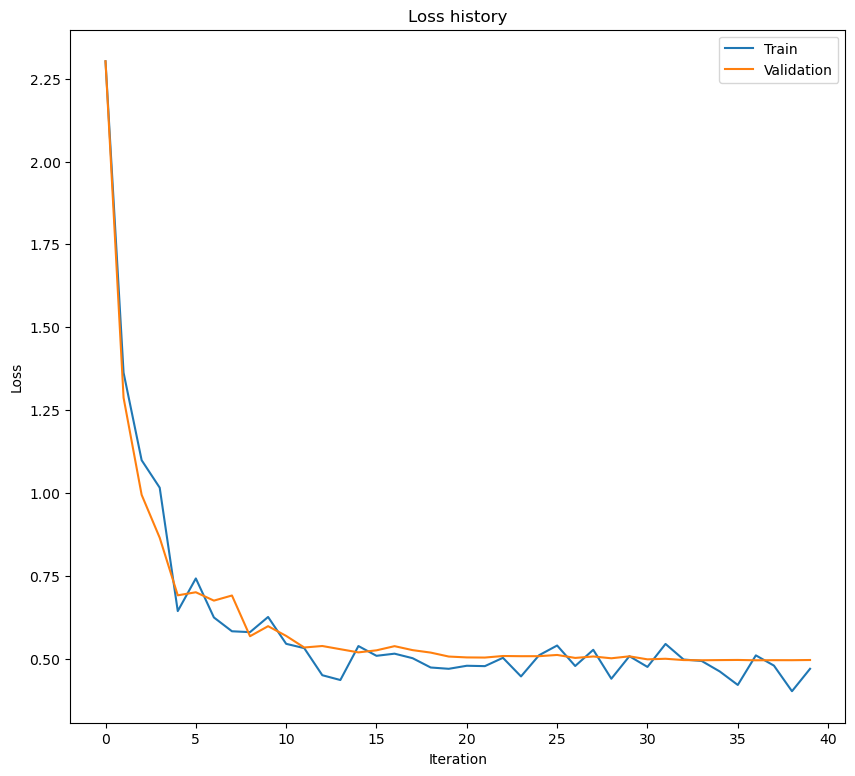

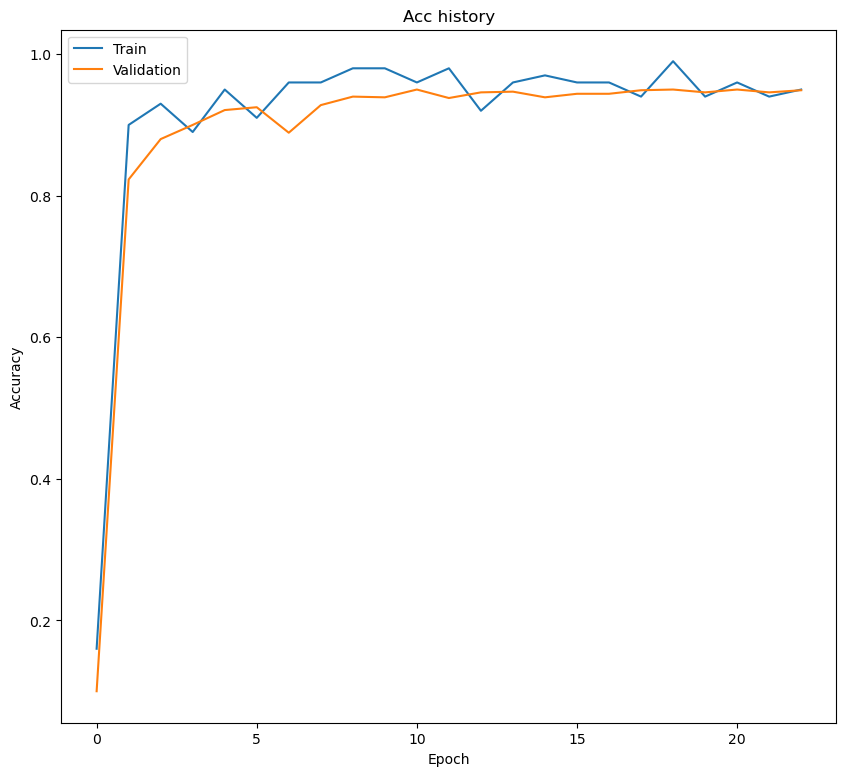

Final accuracy on test set: 0.9480001


In [ ]:
# TODO : show your result
print('Best hidden_size: %d\nBest lr: %e\nBest lr_decay: %e\nBest reg: %e\ntrain accuracy: %f\nval accuracy: %f' %
     (best_hidden_size, best_lr, best_lr_decay, best_reg, results[(best_lr, best_reg, best_lr_decay )][0], results[(best_lr, best_reg,  best_lr_decay )][1]))

params_test = Network.init(input_size = input_size, hidden_size = best_hidden_size, output_size = num_classes, random_seed = random_seed)
stats_test, best_params_test = Network.train(params_test, X_train, y_train, X_val, y_val, random_seed = random_seed,
                learning_rate=best_lr, momentum=0.9, wd_decay=best_reg, lr_decay = best_lr_decay,
                num_iters=num_iters, batch_size=batch_size,
                do_early_stopping=True,
                print_every=50, verbose=True)
test_utils.plot_loss_history(stats_test['loss_history'], stats_test['val_loss_history'])
test_utils.plot_acc_history(stats_test['acc_history'], stats_test['val_acc_history'])
print('Final accuracy on test set:', Network.get_acc(best_params_test, X_test, y_test))